In [443]:
___Author___='LumberJack Jyss'

In [444]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [445]:
print('Importing librairies...')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline
print('Librairies imported')

Importing librairies...
Librairies imported


In [446]:
import warnings
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

In [447]:
df_1D = pd.read_csv('20190526 data prepared.csv')
df_1D = df_1D.iloc[:,1:]
df_1D = df_1D.dropna()
df_1D.reset_index(inplace=True,drop=True)

In [448]:
df_1D.isnull().sum().sum()

0

In [449]:
df_1D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 23 columns):
Date                  1208 non-null int64
Varop_Spy             1208 non-null float64
Varhl_spy             1208 non-null float64
RSI                   1208 non-null float64
75 - RSI              1208 non-null float64
RSI - 25              1208 non-null float64
BBD_Delta_Up          1208 non-null float64
delta5_8              1208 non-null float64
delta8_10             1208 non-null float64
delta10_12            1208 non-null float64
delta12_15            1208 non-null float64
delta15_30            1208 non-null float64
delta30_35            1208 non-null float64
delta35_40            1208 non-null float64
delta40_45            1208 non-null float64
delta45_50            1208 non-null float64
delta_tsf             1208 non-null float64
Forcast Oscillator    1208 non-null float64
Peak                  1208 non-null int64
Valley                1208 non-null int64
target_up          

plt.figure(figsize=(26,20))
sns.heatmap(df_1D.iloc[:,:-1].corr(),annot=True,cmap='rainbow')
plt.show()

In [450]:
df_1D.shape

(1208, 23)

In [451]:
df_1D['target_up'].sum(),df_1D['target_down'].sum()

(40, 41)

In [452]:
delta = round(df_1D.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,' periods (',df_1D.iloc[bloc1,0],')\nBloc 2 :',bloc2,' periods (',df_1D.iloc[bloc2,0],')')
print('First period :',df_1D.iloc[0,0])
print('Last period :',df_1D.iloc[df_1D.shape[0]-1,0])


# of periods :  1208
On 80% - 20% slash : 
Bloc 1 :  966  periods ( 20180618 )
Bloc 2 : 242  periods ( 20150803 )
First period : 20140815
Last period : 20190604


In [453]:
X = df_1D.iloc[:,1:-3]
#X = X.drop(['Peaks','Valley'],axis=1)
#X = X.drop(['75 - RSI','RSI - 25'],axis=1)
y_up = df_1D.iloc[:,-3].values
y_down = df_1D.iloc[:,-2].values

In [454]:
Xtrain = X.iloc[:bloc1,:]
Xtest = X.iloc[bloc1:,:]
ytrain_up = y_up[:bloc1]
ytest_up = y_up[bloc1:]
ytrain_down = y_down[:bloc1]
ytest_down = y_down[bloc1:]

In [455]:
scaler = MinMaxScaler(feature_range=(0, 1))
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.fit_transform(Xtest)
#y_up = scaler.fit_transform(np.array(y_up).reshape(-1,1))
#y_down = scaler.fit_transform(np.array(y_down).reshape(-1,1))
y_up = np.array(y_up).reshape(-1,1)
y_down = np.array(y_down).reshape(-1,1)

In [456]:
Xtrain.shape,ytrain_up.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape

((966, 19), (966,), (966,), (242,), (242,))

In [457]:
param = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':1
}

num_rounds = 20

In [458]:
weights_up = np.zeros(len(ytrain_up))
weights_up[ytrain_up == 0] = 1
weights_up[ytrain_up == 1] = 10

In [459]:
weights_down = np.zeros(len(ytrain_down))
weights_down[ytrain_down == 0] = 1
weights_down[ytrain_down == 1] = 10

In [460]:
dtrain_up = xgb.DMatrix(Xtrain,label=ytrain_up,weight=weights_up)
dtrain_down = xgb.DMatrix(Xtrain,label=ytrain_down,weight=weights_down)
dtest = xgb.DMatrix(Xtest)

In [461]:
train_labels_up=dtrain_up.get_label()
train_labels_down=dtrain_down.get_label()
ratio_up = float(np.sum(train_labels_up == 0))/np.sum(train_labels_up == 1)
ratio_down = float(np.sum(train_labels_down == 0))/np.sum(train_labels_down == 1)
param['scale_pos_weights_up'] = ratio_up
param['scale_pos_weights_down'] = ratio_down

In [462]:
bst_up = xgb.train(param,dtrain_up,num_rounds)
yhat_up = (bst_up.predict(dtest) > 0.47).astype('int')

bst_down = xgb.train(param,dtrain_down,num_rounds)
yhat_down = (bst_down.predict(dtest) > 0.47).astype('int')

In [463]:
pd.crosstab(pd.Series(ytest_up,name='actual'),pd.Series(yhat_up,name='predicted'),margins=True)

predicted,0,1,All
actual,,,
0,214,19,233
1,3,6,9
All,217,25,242


In [464]:
pd.crosstab(pd.Series(ytest_down,name='actual'),pd.Series(yhat_down,name='predicted'),margins=True)

predicted,0,1,All
actual,,,
0,229,4,233
1,8,1,9
All,237,5,242


In [465]:
accuracy_up = accuracy_score(ytest_up, yhat_up)
accuracy_down = accuracy_score(ytest_down, yhat_down)

# La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
precision_up = precision_score(ytest_up, yhat_up)  
precision_down = precision_score(ytest_down, yhat_down) 


# Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
recall_up = recall_score(ytest_up, yhat_up) 
recall_down = recall_score(ytest_down, yhat_down) 


roc_up=roc_auc_score(ytest_up,yhat_up)
roc_down=roc_auc_score(ytest_down,yhat_down)

In [466]:
print('RESULTATS UP\n')
print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("AUC: %.2f%% " % (roc_up *100))
# get probabilities for positive class

print(classification_report(ytest_up, yhat_up))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_up, yhat_up))
print('Matrice de confusion :')
conf_matrix

RESULTATS UP

Accuracy: 90.91%
Precision: 24.00%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 66.67%   => Positifs trouvés par Golem sur tous les positifs existants
AUC: 79.26% 
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       233
           1       0.24      0.67      0.35         9

   micro avg       0.91      0.91      0.91       242
   macro avg       0.61      0.79      0.65       242
weighted avg       0.96      0.91      0.93       242

[[214  19]
 [  3   6]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [467]:
print('RESULTATS DOWN\n')
print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("AUC: %.2f%% " % (roc_down *100))
# get probabilities for positive class

print(classification_report(ytest_down, yhat_down))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_down, yhat_down))
print('Matrice de confusion :')
conf_matrix

RESULTATS DOWN

Accuracy: 95.04%
Precision: 20.00%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 11.11%   => Positifs trouvés par Golem sur tous les positifs existants
AUC: 54.70% 
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       233
           1       0.20      0.11      0.14         9

   micro avg       0.95      0.95      0.95       242
   macro avg       0.58      0.55      0.56       242
weighted avg       0.94      0.95      0.94       242

[[229   4]
 [  8   1]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [468]:
len(ytest_up)

242

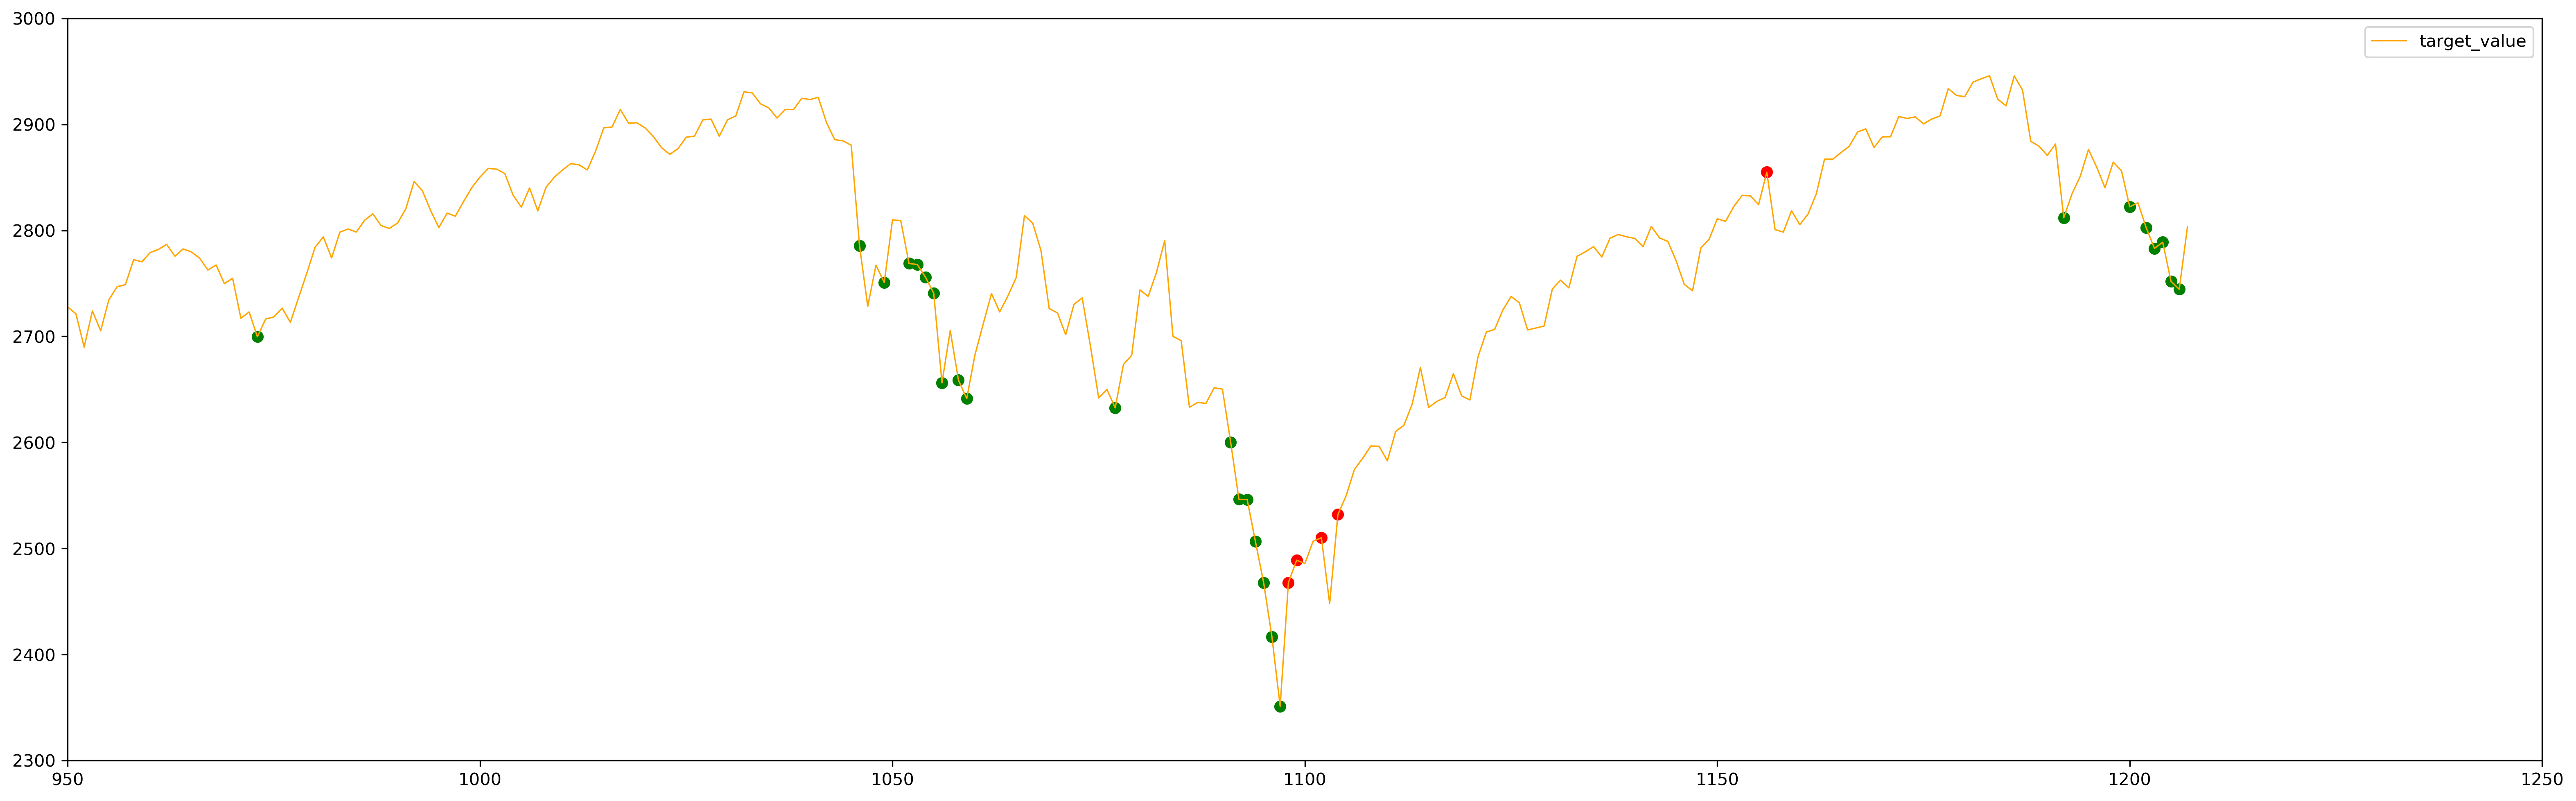

In [469]:
plt.figure(figsize=(26,8),dpi=300)
plt.plot(df_1D['target_value'],color='orange',lw=0.8)
plt.xlim(950,1250)
plt.ylim(2300,3000)
a = -1
for i in range(len(df_1D)-242,len(df_1D)):
    a+=1
    if yhat_up[a] == 1:
        plt.scatter(x=df_1D.index[i],y=df_1D.iloc[i,-1],c='g',marker='o')
    elif yhat_down[a] == 1:
        plt.scatter(x=df_1D.index[i],y=df_1D.iloc[i,-1],c='r',marker='o')
plt.legend()

In [470]:
sum(yhat_up),sum(yhat_down)

(25, 5)

In [471]:
# save the model to disk
filename = 'finalized_model_long.sav'
pickle.dump(model_up, open(filename, 'wb'))
filename = 'finalized_model_short.sav'
pickle.dump(model_down, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

In [472]:
df= pd.read_csv('20190526 data prepared.csv')
df = df.iloc[:,1:]
forecast_input = df.iloc[-1,:].shift(-1)
df = df.dropna()
df.reset_index(inplace=True,drop=True)
df.head()

,Date,Varop_Spy,Varhl_spy,RSI,75 - RSI,RSI - 25,BBD_Delta_Up,delta5_8,delta8_10,delta10_12,...,delta35_40,delta40_45,delta45_50,delta_tsf,Forcast Oscillator,Peak,Valley,target_up,target_down,target_value
0,20140815,3.81,22.54,52.059990,22.940010,27.059990,30.136516,9.39725,1.30575,1.152167,...,0.204643,1.488500,1.328600,1936.561209,1.502863,0,0,0,0,1955.06
1,20140818,-13.38,13.63,58.083442,16.916558,33.083442,36.181491,9.92375,4.46825,1.004667,...,0.290893,0.919583,1.673267,1951.420879,1.784150,0,0,0,0,1971.74
2,20140819,-8.87,9.84,61.187862,13.812138,36.187862,41.401770,10.49000,7.33300,2.439500,...,0.426714,0.420556,2.040444,1969.059780,1.522967,0,0,0,0,1981.60
3,20140820,-6.05,10.89,62.670504,12.329496,37.670504,38.723513,11.58300,7.57100,5.106500,...,-0.109679,0.344472,2.315378,1980.793956,0.878436,0,0,0,0,1986.51
4,20140821,-5.55,7.94,64.417553,10.582447,39.417553,40.862630,12.08975,6.22225,7.373167,...,-0.423536,0.379028,2.132222,1991.390989,0.581019,0,0,0,0,1992.37


In [473]:
#forecast_input = forecast_input.iloc[:-1]
forecast_input

Date                   -40.760000
Varop_Spy               41.860000
Varhl_spy               44.054547
RSI                     30.945453
75 - RSI                19.054547
RSI - 25                67.011172
BBD_Delta_Up           -15.952000
delta5_8               -14.001000
delta8_10               -7.594833
delta10_12              -8.398167
delta12_15             -45.270000
delta15_30              -5.663429
delta30_35              -2.543071
delta35_40              -0.245722
delta40_45               5.962022
delta45_50            2754.018571
delta_tsf                1.657795
Forcast Oscillator       0.000000
Peak                     0.000000
Valley                   0.000000
target_up                1.000000
target_down           2803.400000
target_value                  NaN
Name: 1256, dtype: float64

In [474]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(Xtrain, ytrain_up,
        eval_set=[(Xtrain, ytrain_up), (Xtest, ytest_up)],
        early_stopping_rounds=50,
       verbose=False)

[20:18:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

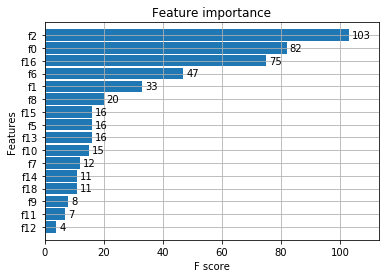

In [475]:
_ = plot_importance(reg, height=0.9)

In [476]:
Xtest.shape,ytest_up.shape

((242, 19), (242,))

In [477]:
pred_up = reg.predict(Xtest)

In [478]:
mean_squared_error(y_true=ytest_up,
                   y_pred=pred_up)

0.05652232620027525

In [479]:
mean_absolute_error(y_true=ytest_up,
                   y_pred=pred_up)

0.15798640793020075

In [480]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [481]:
mean_absolute_percentage_error(y_true=ytest_up,
                   y_pred=pred_up)

inf

In [482]:
diff = ytest_up - pred_up

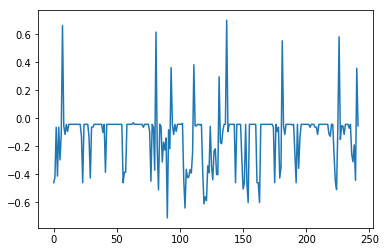

In [483]:
plt.plot(diff)

In [484]:
ytest_up[-1],pred_up[-1],diff[-1]

(0, 0.052821577, -0.052821576595306396)